<a href="https://colab.research.google.com/github/delaltomruk/data-science-data/blob/main/tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of the competition is to create a classifier capable of determining a dog's breed from a photo.

## Preparing the Data

In [3]:
# import all libraries
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd 
import numpy as np
import os
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
df

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [5]:
#create the path for each image
path_names = ["drive/MyDrive/Dog Vision/train/" + image_name + ".jpg" for image_name in df["id"]]
path_names[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [6]:
#change the breeds column to a numpy array, we need numerical columns!
breeds = df["breed"].to_numpy()
breeds[:5]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever'],
      dtype=object)

In [7]:
unique_breeds = np.unique(breeds)
unique_breeds[:5]

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier'], dtype=object)

In [8]:
# create a boolean array to keep track of breeds
boolean_breed = [unique_breeds == breed for breed in breeds]
boolean_breed[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

Create the validation data - which was not given with Kaggle dataset.

In [9]:
X = path_names
y = boolean_breed

In [10]:
NUM_IMAGES = 1000

#split the data to validation set

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size = 0.2,
                                                  random_state = 42)

In [11]:
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

## Turn the Images to Tensors

In [12]:
# function for preprocessing the images

IMG_SIZE = 224 # why 224? 
               # see the link: https://datascience.stackexchange.com/questions/16601/reason-for-square-images-in-deep-learning

def preprocess_image(image_path, img_size = IMG_SIZE):
  """
  Takes an image file path and turns it into a Tensor. 
  """

  # read the image file
  image = tf.io.read_file(image_path)
  # turn the image to tensors for different color channels (red, blue, green)
  image = tf.image.decode_jpeg(image, channels = 3) # 3 outputs and RBG image
  # convert the color channel values to a scale 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)
  # resize the image
  image = tf.image.resize(image,size = [img_size, img_size])

  return image



## Turning Data Into Batches

Default batch size is 32!
See: https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu

All 1000+ images might not fit into memory, so doing 32 (batch size) images at a time is faster. you can adjust the batch size if needed.

In [13]:
# function to return a tuple '(image, breed)'

def get_tuple(image_path, breed):
  """
  Takes an image file path name and the associated label,
  preprocesses the image and returns a tuple of (image, breed).
  """
  image = preprocess_image(image_path)
  return image, breed


In [14]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) 
    batch = data.map(preprocess_image).batch(batch_size)
    return batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), 
                                               tf.constant(y)))
    batch = data.map(get_tuple).batch(batch_size)
    return batch

  else:
    # it is the training set, we should shuffle for randomness
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), 
                                              tf.constant(y))) 
    
   
    data = data.shuffle(buffer_size=len(X)) # buffer size decides on the randomness e.g. buffer_size = 1 is no shuffle at all

    # Create tuples - this  turns the image path into a preprocessed image
    data = data.map(get_tuple)

    batch = data.batch(batch_size)
    return batch

In [15]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

## Visualizing the Data

In [23]:
def show_25_images(images, labels):
  """
  shows 25 images using batches
  """
  # set the figure up
  plt.figure(figsize= (10,10))

  for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[(labels[i].arg_max())]) # bunu anlamadim
    
    



AttributeError: ignored

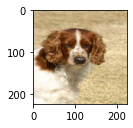

In [24]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels) 
# this will change everytime we run the code, because this is the training set and we shuffled the training set

In [ ]:
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels) #this will stay the same everytime it runs, because we are not shuffling the validation set

# Let's build the model!

In [ ]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels
OUTPUT_SHAPE = len(unique_breeds) # output an array of size len
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"